# Arctic Penguin Exploration: Unraveling Clusters in the Icy Domain with K-means clustering

![Alt text](https://imgur.com/orZWHly.png)
source: @allison_horst https://github.com/allisonhorst/penguins

You have been asked to support a team of researchers who have been collecting data about penguins in Antartica! 

**Origin of this data** : Data were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica LTER, a member of the Long Term Ecological Research Network.

**The dataset consists of 5 columns.**

- culmen_length_mm: culmen length (mm)
- culmen_depth_mm: culmen depth (mm)
- flipper_length_mm: flipper length (mm)
- body_mass_g: body mass (g)
- sex: penguin sex

Unfortunately, they have not been able to record the species of penguin, but they know that there are three species that are native to the region: **Adelie**, **Chinstrap**, and **Gentoo**, so your task is to apply your data science skills to help them identify groups in the dataset!

In [143]:
# packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# dataset
penguins_df = pd.read_csv("/Users/dani/Data Science/Projects/DataCamp Projects/Clustering Antartic Penguin Species/datasets/penguins.csv")

EDA

In [144]:
penguins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB


In [145]:
penguins_df.isna().sum().sort_values()
# straight off the bat can see a small amount of rows containing null values (less than 5% of total values)

culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

In [146]:
penguins_df[penguins_df.sex.isna()] 
# looking into the sex column, there is a possibility of imputing 7 out of the 9 rows with a null value with mode (given it's a category)
# or, we can simply remove since it's within our threshold for NaN removals

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
3,NaN,NaN,NaN,NaN,NaN
8,34.1,18.1,193.0,3475.0,NaN
10,37.8,17.1,186.0,3300.0,NaN
11,37.8,17.3,180.0,3700.0,NaN
47,37.5,18.9,179.0,2975.0,NaN
246,44.5,14.3,216.0,4100.0,NaN
286,46.2,14.4,214.0,4650.0,NaN
324,47.3,13.8,216.0,4725.0,NaN
339,NaN,NaN,NaN,NaN,NaN


In [147]:
penguins_df.dropna(inplace=True)

In [148]:
penguins_df.info()
# confirming drop

<class 'pandas.core.frame.DataFrame'>
Index: 335 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   335 non-null    float64
 1   culmen_depth_mm    335 non-null    float64
 2   flipper_length_mm  335 non-null    float64
 3   body_mass_g        335 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 15.7+ KB


In [149]:
penguins_df['sex'] = penguins_df['sex'].astype('category')

In [150]:
penguins_df.describe()
# we will have to standardize/normalize the data from our statistical insights below and take outliers into account

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
count,335.000000,335.000000,335.000000,335.000000
mean,43.988358,17.169552,214.355224,4209.179104
std,5.453430,1.971966,263.253508,803.633495
min,32.100000,13.100000,-132.000000,2700.000000
25%,39.500000,15.600000,190.000000,3550.000000
50%,44.500000,17.300000,197.000000,4050.000000
75%,48.550000,18.700000,213.000000,4787.500000
max,59.600000,21.500000,5000.000000,6300.000000


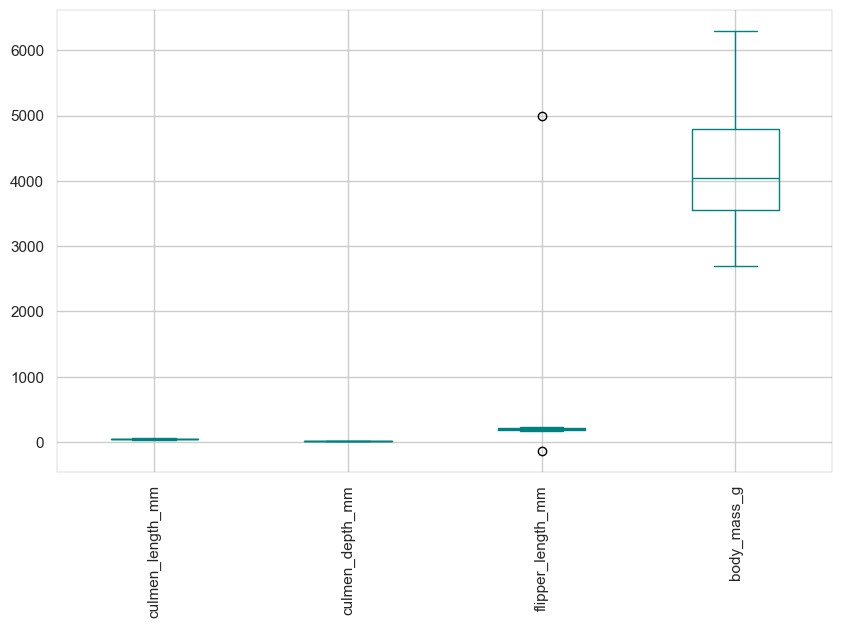

In [151]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(10, 6))

penguins_df.boxplot(color="teal") 
# confirming outliers under the flipper_length_mm feature
plt.xticks(rotation=90)
plt.show()

In [152]:
def outlier_removal(df, column):
    # first and third quartile
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    
    # interquartile range
    IQR = q3 - q1
    
    # lower and upper bound
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    # outlier removal 
    return df[(df[column] > lower_bound) & (df[column] < upper_bound)]

In [153]:
penguins_clean = outlier_removal(penguins_df, 'flipper_length_mm')

Preprocessing

In [154]:
penguins_dummies = pd.get_dummies(penguins_clean.sex, drop_first=True)
# creating dummy variables and dropping the feature column

penguins_dummies = pd.concat([penguins_clean, penguins_dummies], axis=1)
penguins_dummies = penguins_dummies.drop('sex', axis=1)

In [155]:
scaler = StandardScaler()
# standardizing features to get them ready for the models

penguins_scaled = scaler.fit_transform(penguins_dummies)

penguins_preprocessed = pd.DataFrame(penguins_scaled, columns=penguins_dummies.columns)

Principal Component Analysis (PCA)

In [156]:
model = PCA()
model.fit(penguins_preprocessed)

n_components = sum(model.explained_variance_ratio_ > 0.1)
# considering components above a 10% ratio

penguins_PCA = PCA(n_components=n_components).fit_transform(penguins_preprocessed)

KMeans Clustering

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

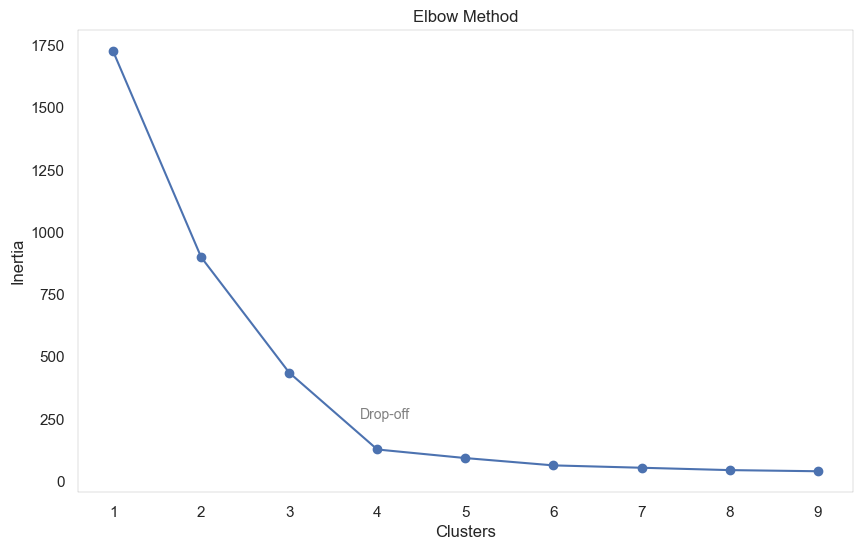

In [157]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(10, 6))

random_state = 42

inertia = []
for k in range(1,10):
    '''Elbow analysis:
    Determining the optimal number of clusters for this dataset
    '''
    kmeans = KMeans(n_clusters=k, random_state=random_state).fit(penguins_PCA)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10), inertia, marker='o')
plt.xlabel('Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
ax.text(3.8, 250, "Drop-off", fontsize = 10, color = "gray", rotation = 0)
plt.show()

n_clusters = 4
# cluster selection based off of the elbow analysis below

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


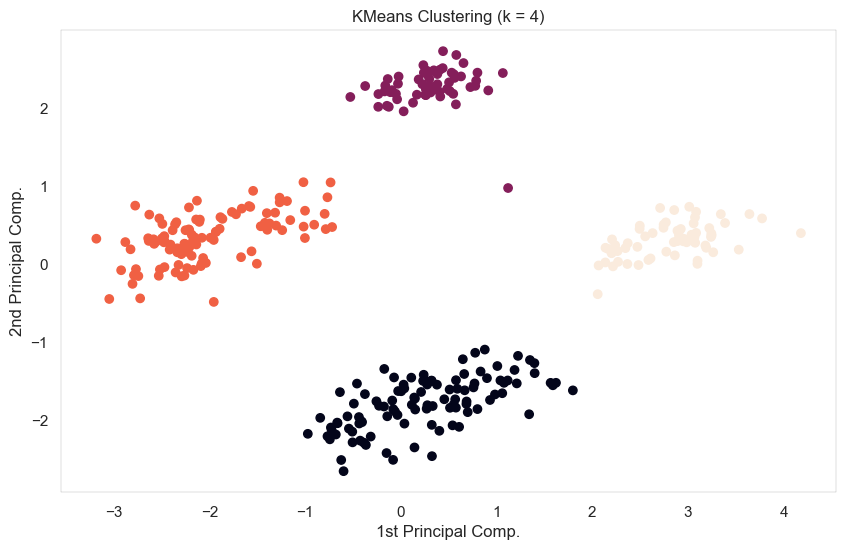

In [158]:
sns.set(style="white", color_codes=True)
plt.rcParams['axes.linewidth'] = 0.1
fig, ax = plt.subplots(figsize=(10, 6))

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(penguins_PCA)

plt.scatter(penguins_PCA[:,0], penguins_PCA[:,1], c=kmeans.labels_)
plt.xlabel('1st Principal Comp.')
plt.ylabel('2nd Principal Comp.')
plt.title(f"KMeans Clustering (k = {n_clusters})")
plt.show()

In [159]:
penguins_clean['label'] = kmeans.labels_

/var/folders/wc/6x35sr293njgq8g1xgc9fzlm0000gn/T/ipykernel_66091/2184060126.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_clean['label'] = kmeans.labels_


In [160]:
numeric_col = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

stat_penguins = penguins_clean.groupby('label')[numeric_col].mean()

display(stat_penguins)

,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
label,,,,
0,43.878302,19.111321,194.764151,4006.603774
1,45.545763,14.262712,212.779661,4683.050847
2,40.217757,17.611215,189.046729,3419.158879
3,49.473770,15.718033,221.540984,5484.836066
